# Ciencia de datos aplicada

## Taller 3

### Contexto

The goal for this analysis was to look for relationships between socioeconomic status and cancer by way of combining data from disparate open sources. I hypothesized that poorer regions would have fewer trials, and higher per capita cancer incidence and death rates.

[contributors-wanted](https://data.world/nrippner/cancer-trials). Comment in the discussion thread or 'request invite' under contributor tab if you're interested. I'd also love to hear if you have any ideas for moving this project forward or in new directions.

This analysis Joins data from clinicaltrials.gov, cancer.gov & census.gov to examine cancer trials, mortality, incidence and demographics.
 

### Objetivos

1. Encontrar las estadísticas básicas de los datos
2. Preparar los datos para el modelado.
3. Construir el modelo de regresión lineal.
4. Evaluar el modelo.
5. Interpretar el modelo.


### 1. Importación de librerías y datos

En las siguientes líneas de código se importan las librerías, datos y herramientas necesarias para desarrollar el caso de uso.

In [91]:
#Librería de manejo de datos
import pandas as pd
# Manejo de json
import json

# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para construir un modelo con el algoritmo de regresión lineal
from sklearn.linear_model import LinearRegression
# Librería para parámetros polinomiales
from sklearn.preprocessing import PolynomialFeatures

# Para determinar el rendimiento del modelo con las métricas MSE, MAE y R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Para sacar un reporte estadístico que podemos usar para determinar las importancia de las variables explicativas.
import statsmodels.api as sm 



#Pandas profiling
from pandas_profiling import ProfileReport

#Librería para graficar
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
# Se cargan los datos
data=pd.read_csv('cancer_reg.csv')

In [93]:
#Json con el diccionario de archivos
with open('diccionario_variables.json') as json_file:
    diccionario_variables = json.load(json_file)

In [94]:
# Cantidad de datos y número de variables
data.shape

(3047, 34)

In [95]:
# Mostrar los datos
data.head()

avgAnnCount  avgDeathsPerYear  TARGET_deathRate  incidenceRate  medIncome  \
0       1397.0               469             164.9          489.8      61898   
1        173.0                70             161.3          411.6      48127   
2        102.0                50             174.7          349.7      49348   
3        427.0               202             194.8          430.4      44243   
4         57.0                26             144.4          350.1      49955   

   popEst2015  povertyPercent  studyPerCap           binnedInc  MedianAge  \
0      260131            11.2   499.748204   (61494.5, 125635]       39.3   
1       43269            18.6    23.111234  (48021.6, 51046.4]       33.0   
2       21026            14.6    47.560164  (48021.6, 51046.4]       45.0   
3       75882            17.1   342.637253    (42724.4, 45201]       42.8   
4       10321            12.5     0.000000  (48021.6, 51046.4]       48.3   

   ...  PctPrivateCoverageAlone  PctEmpPrivCoverage PctPublicCoverage  \
0  ...                      NaN                41.6              32.9   
1  ...                     53.8                43.6              31.1   
2  ...                     43.5                34.9              42.1   
3  ...                     40.3                35.0              45.3   
4  ...                     43.9                35.1              44.0   

   PctPublicCoverageAlone   PctWhite  PctBlack  PctAsian  PctOtherRace  \
0                    14.0  81.780529  2.594728  4.821857      1.843479   
1                    15.3  89.228509  0.969102  2.246233      3.741352   
2                    21.1  90.922190  0.739673  0.465898      2.747358   
3                    25.0  91.744686  0.782626  1.161359      1.362643   
4                    22.7  94.104024  0.270192  0.665830      0.492135   

   PctMarriedHouseholds  BirthRate  
0             52.856076   6.118831  
1             45.372500   4.333096  
2             54.444868   3.729488  
3             51.021514   4.603841  
4             54.027460   6.796657  

[5 rows x 34 columns]

In [96]:
#Mostrar los archivos
diccionario_variables

{'studyCount': 'Number of cancer clinical trails (all cancers)',
 'State': nan,
 'PovertyEst': 'Total number of people below poverty line',
 'PovertyPercent': 'Percent of population below poverty line',
 'medIncome': 'Median household income by county',
 'Name': 'County name',
 'popEst2015': 'Estimated population by county 2015',
 'County ': nan,
 'incidenceRate': 'Cancer (all cancers) age-adjusted incidence per 100,000',
 'avgAnnCount': '2009-2013 mean incidences per county',
 'recentTrend': 'incidence recent trend',
 'fiveYearTrend': 'incidence five year trend',
 'countyName': nan,
 'deathRate': 'deaths from cancer per  100,000 per county',
 'avgDeathsPerYear': 'average number of deaths per county per year (2009-2013)',
 'recTrend': 'cancer mortality recent trend'}

In [97]:
#Tipos de datos
data.dtypes

avgAnnCount                float64
avgDeathsPerYear             int64
TARGET_deathRate           float64
incidenceRate              float64
medIncome                    int64
popEst2015                   int64
povertyPercent             float64
studyPerCap                float64
binnedInc                   object
MedianAge                  float64
MedianAgeMale              float64
MedianAgeFemale            float64
Geography                   object
AvgHouseholdSize           float64
PercentMarried             float64
PctNoHS18_24               float64
PctHS18_24                 float64
PctSomeCol18_24            float64
PctBachDeg18_24            float64
PctHS25_Over               float64
PctBachDeg25_Over          float64
PctEmployed16_Over         float64
PctUnemployed16_Over       float64
PctPrivateCoverage         float64
PctPrivateCoverageAlone    float64
PctEmpPrivCoverage         float64
PctPublicCoverage          float64
PctPublicCoverageAlone     float64
PctWhite            

### 2. Preparación de los datos

Antes de realizar cualquier paso de preparación de datos es importante asegurar que estos no contienen errores, como datos faltantes (missing) o duplicados. Es necesario tratar estas ausencias ya que, en general, los algoritmos de aprendizaje no son robustos ante ellas. 

In [98]:
# Es recomendable que todos los pasos preparación se realicen sobre otro archivo.
data_t = data

In [99]:
#Para este caso vamos a utilizar solamente 5 variables del diccionario de variables
variables_seleccionadas=list(diccionario_variables.keys())[0:5]
variables_seleccionadas

['studyCount', 'State', 'PovertyEst', 'PovertyPercent', 'medIncome']

In [100]:
#Incluimos los datos que sean de tipo numérico
variables_seleccionadas=data.select_dtypes(include=["number"]).columns[0:10]
variables_seleccionadas

Index(['avgAnnCount', 'avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate',
       'medIncome', 'popEst2015', 'povertyPercent', 'studyPerCap', 'MedianAge',
       'MedianAgeMale'],
      dtype='object')

In [101]:
#Se selecciona el subconjunto del dataset
data_t=data_t[variables_seleccionadas]

In [102]:
# Podemos comprobar las ausencias con esta línea de código. 
data_t.isna().sum()/len(data_t)

avgAnnCount         0.0
avgDeathsPerYear    0.0
TARGET_deathRate    0.0
incidenceRate       0.0
medIncome           0.0
popEst2015          0.0
povertyPercent      0.0
studyPerCap         0.0
MedianAge           0.0
MedianAgeMale       0.0
dtype: float64

In [103]:
# Eliminación de registros con ausencias. 
data_t=data_t.dropna()

In [104]:
#Cantidad de duplicados
data_t.duplicated().sum()

0

In [105]:
# Eliminación de registros duplicados.
data_t=data_t.drop_duplicates()

Un aspecto muy importante para tener en cuenta son los requerimientos de entrada de los algoritmos de aprendizaje. Cada uno de estos puede trabajar con un tipo de variable. Por ejemplo, para el algoritmo de regresión lineal todas las variables en el conjunto de datos deben ser numéricas. ¿Que pasa si en el conjunto de datos hay variables categóricas? Pues que se debe realizar una transformación de estas variables a un formato numérico.

Esta tranformación se puede realizar de dos formas: asignado un número a cada categoría o representado cada categoría como una variable binaria. Esta útima transformación se conoce como 1-de-n y construye lo que se conoce como variables dummies. En general, es la más recomendada ya que no genera una relación de orden entre las categorías.

### 3. Estadísticas básicas

Describir las propiedades de los datos (estadística descriptiva) y sacar conclusiones sobre una población basándose en la información de una muestra (estadística inferencial).
La distinción entre una población junto con sus parámetros y una muestra junto con sus estadísticas es un concepto fundamental en la estadística inferencial.
La información de una muestra se utiliza para hacer inferencias sobre la población de la que se extrajo la muestra.

In [106]:
#Realizar el perfilamiento
profile = ProfileReport(data_t, title="Perfilamiento de datos")

In [107]:
profile

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

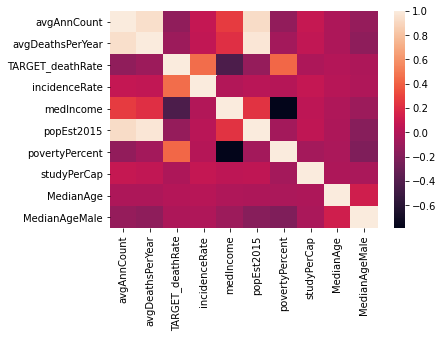

In [108]:
#Realizar el gráfico de correlación
corr = data_t.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

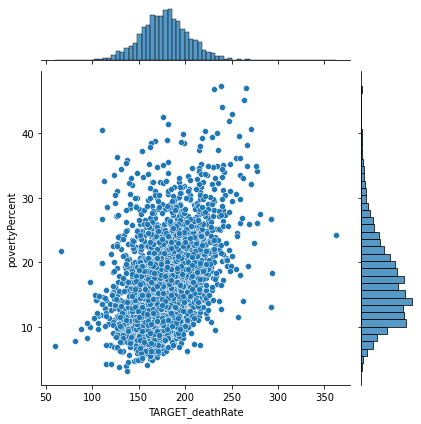

In [109]:
# Graficar las distribuciones y dispersión
sns.jointplot(data=data_t, x="TARGET_deathRate", y="povertyPercent")

### 4. Construcción del modelo

Los algoritmos supervisados implementados en scikit-learn requieren que las variables de entrada estén separadas de la variable objetivo. En este caso, nuestra variable objetivo es la tasa de mortalidad(TARGET_deathRate).

In [110]:
# Se selecciona la variable objetivo, en este caso "TARGET".
Y=data_t['TARGET_deathRate']
# Del conjunto de datos se elimina la variable "TARGET".
X=data_t.drop(['TARGET_deathRate'], axis=1)

A continuación debemos hacer la separación de nuestros datos en un conjunto para el entrenamiento y otro para el test. Recuerda que esta división nos permitirá determinar el rendimiento de generalización del modelo sobre nuevos datos.

El conjunto de entrenamiento se utiliza para ajustar (entrenar) un modelo. Luego, se utiliza el conjunto test para hacer predicciones, las cuales se comparan con los valores esperados para determinar su rendimiento utilizando la métrica seleccionada. 

1. **Train data:** se utiliza para entrenar el modelo con el algoritmo de aprendizaje.
2. **Test data:** se utiliza para evaluar el ajuste del modelo.

![1*-8_kogvwmL1H6ooN1A1tsQ.png](https://miro.medium.com/max/1136/1*-8_kogvwmL1H6ooN1A1tsQ.png)

In [111]:
# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

Antes de construir el modelo debemos crear un objeto de la clase LinearRegression.

In [112]:
# Primero se crea el objeto para construir el modelo
modelo_regresion = LinearRegression()
# Podemos verificar que lo hemos construido.
modelo_regresion

LinearRegression()

In [113]:
# Ajustar el modelo con los datos de entrenamiento
modelo_regresion.fit(X_train,Y_train)

LinearRegression()

### 5. Evaluación del modelo
Las métricas de evaluación nos van a permitir determinar qué tan bien se desempeña un modelo; es decir, cómo se ajusta a los datos. En esta sección se utilizan las siguientes métricas

1. Mean-Squared-Error(MSE). Error medio cuadrático
2. Mean-Absolute-Error(MAE). Error absoluto medio
3. R² or Coeficiente de determinación.

In [114]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = modelo_regresion.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("MSE: %.2f" % mean_squared_error(Y_train, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(Y_train, y_pred))
print('R²: %.2f' % r2_score(Y_train, y_pred))

MSE: 21.20
MAE: 16.02
R²: 0.41


### 6. Interpretación del modelo
También podemos sacar un reporte que nos va a permitir analizar estadísticos del modelo.

In [115]:
# Ajustar el modelo para ver el reporte
model = sm.OLS(Y, X).fit() ## sm.OLS(output, input)
# Mostrar las estadísticas del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       TARGET_deathRate   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                          2.348e+04
Date:                Thu, 16 Sep 2021   Prob (F-statistic):                        0.00
Time:                        17:30:02   Log-Likelihood:                         -13676.
No. Observations:                3047   AIC:                                  2.737e+04
Df Residuals:                    3038   BIC:                                  2.742e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
avgAnnCount         -0.0054      0.001     -6.527      0.000      -0.007      -0.004
avgDeathsPerYear     0.0201      0.004      4.869      0.000       0.012       0.028
incidenceRate        0.2625      0.007     39.835      0.000       0.250       0.275
medIncome         2.543e-05   3.91e-05      0.651      0.515   -5.12e-05       0.000
popEst2015        -1.51e-05   5.86e-06     -2.579      0.010   -2.66e-05   -3.62e-06
povertyPercent       1.9750      0.074     26.645      0.000       1.830       2.120
studyPerCap         -0.0011      0.001     -1.451      0.147      -0.003       0.000
MedianAge           -0.0020      0.009     -0.234      0.815      -0.019       0.015
MedianAgeMale        0.6981      0.060     11.672      0.000       0.581       0.815
==============================================================================
Omnibus:                      174.390   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              719.789
Skew:                          -0.018   Prob(JB):                    5.01e-157
Kurtosis:                       5.381   Cond. No.                     6.83e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 7. Modificación de los parámetros
Qué pasa si cambiamos los parámetros con los que estamos prediciendo, como en las celdas anteriores vimos que la variable **povertyPercent** Tiene una alta correlación, vamos a probar con esa sola variable a ver qué puede pasar

In [116]:
# Se selecciona la variable objetivo, en este caso "TARGET".
Y=data_t['TARGET_deathRate']
# Del conjunto de datos se elimina la variable "TARGET".
X=data_t[['povertyPercent']]

In [117]:
# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

In [118]:
# Primero se crea el objeto para construir el modelo
modelo_regresion = LinearRegression()
# Podemos verificar que lo hemos construido.
modelo_regresion

LinearRegression()

In [119]:
# Ajustar el modelo con los datos de entrenamiento
modelo_regresion.fit(X_train,Y_train)

LinearRegression()

In [120]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = modelo_regresion.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("MSE: %.2f" % mean_squared_error(Y_train, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(Y_train, y_pred))
print('R²: %.2f' % r2_score(Y_train, y_pred))

MSE: 24.96
MAE: 18.95
R²: 0.19


### 8. Regresión polinomial
Si sus puntos de datos claramente no se ajustan a una regresión lineal (una línea recta a través de todos los puntos de datos), podría ser ideal para la regresión polinomial.

La regresión polinomial, como la regresión lineal, usa la relación entre las variables xey para encontrar la mejor manera de trazar una línea a través de los puntos de datos.

Ejemplo:

En caso de tener una variables explicativa [a], el resultado de la transformación polinomial con grado 2 sería el siguiente. [1, a, a^2].


In [121]:
# Utilizaremos una tranformación de grado 2.
poly = PolynomialFeatures(degree=2)
poly_X = poly.fit_transform(X)

In [122]:
# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
poly_X_train, poly_X_test, poly_Y_train, poly_Y_test = train_test_split(poly_X, Y, test_size = 0.2, random_state = 0)

In [123]:
# Creación del objeto de la clase LinearRegression y ajuste del modelo a los datos.
modelo_regresion_poly = LinearRegression()
# Podemos verificar que lo hemos construido.
modelo_regresion_poly

LinearRegression()

In [124]:
# Ajustar el modelo con los datos de entrenamiento con las nuevas variables polinomiales
modelo_regresion_poly.fit(poly_X_train, poly_Y_train)

LinearRegression()

In [125]:
# Se obtienen las predicciones del modelo sobre el conjunto test.
y_pred = modelo_regresion_poly.predict(poly_X_test)

In [126]:
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print('Métricas')
print('------ Modelo de regresión lineal polinomial múltiple----')
print("MSE: %.2f" % mean_squared_error(poly_Y_test, y_pred, squared=True))
print("RMSE: %.2f" % mean_squared_error(poly_Y_test, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(poly_Y_test, y_pred))
print('R²: %.2f' % r2_score(poly_Y_test, y_pred))

Métricas
------ Modelo de regresión lineal polinomial múltiple----
MSE: 638.18
RMSE: 25.26
MAE: 18.97
R²: 0.19


### Extensión

1. Realice la elección de otras variables de su interés
2. Realice la limpieza de datos
3. Encontrar as estadísticas básicas
4. Encontrar el R2 con regresión lineal simple
5. Encontrar el R2 con regresión polinomial

#### La idea es que busquen los parámetros que mayor R2 les de en el modelo 